### Testing "local" vs. "global" effect
It is possible that the nearest neighbor being connected merely indicates that the presynaptic neuron has a high out-degree, which then increases the connection probabilities with _all_ other neurons. We call this the "global" morphology effect.
Alternatively, there can be a spatially limited effect, where the connection probability is increased in a specific area around the nearest neighbor. We call this a "local" morphology effect. 

The total effect can be a mixture of both, and in this notebook we conduct further analyses to further separate them. 

To that end we conduct an analysis of connection probabilities not just against distance, but against horizontal and vertical offsets from the pre-/post-synaptic neuron. 
The global effect will have no specific spatial structure, i.e., the increase in connection probability if the nearest neighbor is connected should be the same at each offset.
Additionally, we analyze also the connectivity of a **configuration model** fitted against the data. That is a model that shuffles the locations of connections, but preserves the in- and out-degrees of all neurons. As the global effect is simply based on some neurons having a higher degree than others, the configuration model will capture it completely.

## Setup
We begin by importing relevant packages and setting up paths.

### Customization options
We have set up this notebook and the paths below for the analysis of the excitatory subgraph of the MICrONS connectome, version 1412.

But you can use it to analyze other connectomes as well, as long as they are formatted in the .hdf5-based format of Connectome-Utilities.

One such example is full_microns_PA.h5, which is created by the notebook "Fit other models to microns" and contains a preferential-attachment model fit to the microns data.

### Caching the results
This analysis is somewhat computationally expensive (~20 minutes for 50k neuron connectomes). Hence, we broke it up into two parts: First, we calculate a pandas.DataFrame that holds pre-digested data. Then we plot the data according to customizable specifications. 

The output of the first, expensive step is saved into a file, such that it does not have to be re-calculated: In future executions it is instead read from the file, unless you set the "force_recalculation" flag to True. 

**Note**: (Update, Dec. 2025): We have updated the notebook to allow filtering for "trustworthy" neurons in the connectome. That is, only some neurons are considered trustworthy for the outgoing connectivity, and a different set is considered trustworthy for the incoming connectivity. Pairs of neurons are only considered for calculation of connection probabilities if the potential presynaptic partner is trustworthy for outgoing connectivity and the postsynaptic partner is trustworthy for incoming connectivity.

The effect is that the results are more noisy and lower p-values are reached, as fewer samples are analyzed. On the other hand, analyses are also much faster.

For the MICrONS data, we suggest limiting outgoing connectivity to neurons with proofread axons and not limiting incoming connectivity not at all, as dendrites require less proofreading than axons. We provide instructions below for setting this up.

In [ ]:
import numpy
import pandas
import h5py
import os

import conntility

from scipy.spatial.distance import cdist
import tqdm

from matplotlib import pyplot as plt
from ipywidgets import widgets, interactive
from ipywidgets import Dropdown, SelectMultiple

# Location of the file holding the connectome information
# Obtain the file at https://doi.org/10.5281/zenodo.16744240 (MICrONS data)
# or at https://doi.org/10.5281/zenodo.16744766 (Potential connectivity of an SSCX model)
fn_connectivity = "microns_mm3_connectome_v1412.h5"

# Location of the file for storing/caching results of the compuations. If it does not exists, it will be created.
# The file below already has the relevant results pre-calculted.
fn_digest_dataframe = os.path.splitext(fn_connectivity)[0] + "_digest.h5"

# If you set this flag to True, expensive calculations will be repeated even if the result already exists in the cache file above.
# Note: If you set this to True you will have to update "fn_digest_dataframe" to a different, local path. This is because the 
# default location of "fn_digest_dataframe" is on a read-only file system.
force_recalculation = True


## Selecting the connection matrix
We read a connection matrix from an .h5 file. However, a file can contain more than one connection matrix. 

**Select the one to analyze from the dropdown.**

If you are using the recommended file, then you can choose between "condensed" and "full". The "full" matrix represents the connectome as a multigraph, i.e., multiple synapses from one neuron to another are represented by multiple edges. In "condensed" only one edge is placed, but it will have a property "count" that lists the number of edges in the "full" connectome. 

Which of the two you select will make no difference, as we convert the multigraph version to a condensed view anyways.

If you are using one of the files containing control connectomes, then you can select the instance of the control.

In [2]:
with h5py.File(fn_connectivity, "r") as h5:
    contents = []
    prefixes = list(h5.keys())
    for prefix in prefixes:
        [contents.append(prefix + "/" + _k) for _k in h5[prefix].keys()]

sel_matrix = widgets.Dropdown(options=contents, index=0, description="Select matrix")
display(sel_matrix)

Dropdown(description='Select matrix', options=('connectivity/condensed', 'connectivity/full'), value='connecti…

We load the selected connectivity matrix.
If it is a multigraph, we convert it not to be one.

In [3]:
selected = str(sel_matrix.value)
M = conntility.ConnectivityMatrix.from_h5(fn_connectivity, 
                                          prefix=sel_matrix.value.split("/")[0],
                                          group_name=sel_matrix.value.split("/")[1])
if M.is_multigraph:
    M = M.compress()
print(f"Loaded {len(M)} nodes with {len(M.edges)} edges from {selected}")

# Create a subcircuit using the .index functionality. The following creates the subcircuit of neurons where 
# the values of "synapse_class" is equal to "EXC".
M = M.index("classification_system").eq("excitatory_neuron")
print(f"Reduced numbers to {len(M)} excitatory neurons")

col_y = "y"
col_xz = ["x", "z"]
# This flag indicates whether y indicates a "depth", i.e. is counted from the top of L1 (True), or a reverse depth, counted from the bottom of L6 (False).
# This is relevatn purely for plotting purposes at the end.
y_is_depth = True


Loaded 50948 nodes with 7463640 edges from connectivity/condensed
Reduced numbers to 45598 excitatory neurons


## Select a trustworthy subset of neurons

Some datasets (e.g., EM connectomes) require proofreading to provide trustworthy connectivity data.
Here, we will build up two separate filters that determine whether we consider a neuron to have trustworthy outgoing and incoming connectivity data

### Neurons to consider for outgoing connectivity

In the following dropdown, please select a vertex (neuron) property that will serve as the basis for a filter. The filter will be used to determine neurons with trustworthy *outgoing* connectivity.

**Hint**: For MICrONS EM connectome data, use "status_axon". The rationale is, that we consider a neurons outgoing connectivity only if the *axon* has been proofread. For data from computational models filtering is not required. Therefore, you can leave the dropdown at "*no filtering*".

In [4]:
no_fltr = "No filtering"
select_fltr_row = Dropdown(options=[no_fltr, *M.vertex_properties],
                           description="OUTGOING")
display(select_fltr_row)

Dropdown(description='OUTGOING', options=('No filtering', 'layer', 'mtype', 'pt_root_id', 'volume', 'pt_superv…

Next, select all possible values of the selected neuron property that indicate a *trustworthy* neuron, i.e., a neuron that we **do** want to consider for outgoing connectivity.

**Hint**: For MICrONS and "status_axon", select "t"

If "No filtering" was selected, nothing will be displayed.

In [5]:
select_vals_row = None
if select_fltr_row.value != no_fltr:
    v = M.vertices[select_fltr_row.value].drop_duplicates()
    if len(v) > 20:
        raise ValueError(f"Property {select_fltr_row.value} has too many unique values. Please select a categorical property!")
    select_vals_row = SelectMultiple(options=v, description="Valid values")
    display(select_vals_row)

SelectMultiple(description='Valid values', options=('empty', 't', 'f'), value=())

### Neurons to consider for incoming connectivity

We repeat the same filter setup process for the **incoming** connectivity. 
What is required to consider a neuron's incoming connectivity trustworthy?

In [6]:
select_fltr_col = Dropdown(options=[no_fltr, *M.vertex_properties],
                           description="INCOMING")
display(select_fltr_col)

Dropdown(description='INCOMING', options=('No filtering', 'layer', 'mtype', 'pt_root_id', 'volume', 'pt_superv…

In [7]:
select_vals_col = None
if select_fltr_col.value != no_fltr:
    v = M.vertices[select_fltr_col.value].drop_duplicates()
    if len(v) > 20:
        raise ValueError(f"Property {select_fltr_col.value} has too many unique values. Please select a categorical property!")
    select_vals_col = SelectMultiple(options=v, description="Valid values")
    display(select_vals_col)

Now we assemble the filters according to these specs and get the indices of rows and columns of the matrix that we want to consider.

In [8]:
index_row = M.vertices.index
if select_vals_row is not None:
    index_row = index_row[M.vertices.loc[index_row, select_fltr_row.value].isin(select_vals_row.value)]

index_col = M.vertices.index
if select_vals_col is not None:
    index_col = index_col[M.vertices.loc[index_col, select_fltr_col.value].isin(select_vals_col.values)]
index_row = index_row.to_numpy(); index_col = index_col.to_numpy()

print(f"Considering {len(index_row)} neurons for outgoing, {len(index_col)} neurons for incoming connectivity!")

Considering 1680 neurons for outgoing, 45598 neurons for incoming connectivity!


### Generate spatial bins
We generate spatial bins for the offset of neurons pairs along the y-axis, and their distance in the x/z-plane.
For the y-bins we ensure that they are centered around 0.

We found 50 um to be a good bin size, but you can update it. In that case, you will have to set the "force_recalculate" flag to True.

In [9]:
# It is possible to adjust the bin size of the final plots here.
bin_sz = 50.0 # um


def make_spatial_bins(M_h, cols, bin_sz):
    _data = M_h.vertices[cols]
    delta = _data.max() - _data.min()

    sz = numpy.sqrt((delta.values ** 2).sum())
    if len(delta) == 1: # case 1d: negative and positive bins
        bins = numpy.arange(0, (bin_sz * numpy.ceil(sz / bin_sz)) + bin_sz, bin_sz)
        bins = numpy.hstack([-bins[:0:-1], bins])
    else: # case 2d: Only positive bins, but exclude 0 dist
        bins = numpy.arange(0, (bin_sz * numpy.ceil(sz / bin_sz)) + bin_sz, bin_sz)
        bins = numpy.hstack([[0, 1E-12], bins[1:]])
    return bins

dbins_xz = make_spatial_bins(M, col_xz, bin_sz)
binid_xz = numpy.arange(0, len(dbins_xz) + 1)

dbins_y = make_spatial_bins(M, [col_y], bin_sz)
binid_y = numpy.arange(0, len(dbins_y) + 1)

bin_centers_y = 0.5 * (dbins_y[:-1] + dbins_y[1:])
bin_centers_xz = 0.5 * (dbins_xz[1:-1] + dbins_xz[2:])


## Find nearest neighbors and calculate connectivity with nearest neighbors

We use KDTrees to quickly find nearest neigbors of all neurons.

Then we calculate three sparse matrices:
  - The first simply holds the number of edges between neurons i and j
  - The second holds the number of edges between i and the nearest neigbor of j
  - The third holds the number of edges between the nearest neigbbor of i and j

In [ ]:
from scipy.spatial import KDTree

_coords = col_xz + [col_y]
tree = KDTree(M.vertices[_coords].values)

_, nn_id = tree.query(M.vertices[_coords], k=2)
nn_id = nn_id[:, 1]  # nn_id[:, 0] is the original node, which has distance 0. nn_id[:, 1] is neighbor

# Lookup from pre / post ids to number of edges
pair_to_edge_count = M.edges.set_index(pandas.MultiIndex.from_frame(M._edge_indices))[M._default_edge]

# Edge counts i -> j
edge_count_mat = M.matrix.tocsr()
# Edge counts nn(i) -> j
edge_count_nnpre_mat = edge_count_mat[nn_id]
# Edge counts i -> nn(j)
edge_count_nnpost_mat = edge_count_mat[:, nn_id]


## Main calculation

Here we calculate a DataFrame with the following structure:

Each row represents a possible combination of:
  - spatial bin of the offset in the xz plane of a pair of neurons (i - j)
  - spatial bin of their offset along the y-axis
  - number of edges (synapses) from i to j
  - number of edges (synapses) from i to the nearest neighbor of j

The first four columns list the values of these four properties. **a fifth column then counts the number of pairs of neurons for that combination**.

Additionally, we calculate a second DataFrame that is very similar, except the fourth column represents instead the number of edges (synapses) from the nearest neighbor of i to j.


For this calculation we have to consider the distances between all pairs of neurons. For large connectomes this can result in a very large matrix. To avoid running out of memory on weaker machines, we conduct the analysis in chunks of 2500 neurons. In the next cell, we define the function we run for each chunk. 

In [11]:
# Execute the analysis for a given set of _rows_ of the connectivity matrix
def for_pre_chunk(chunk_pre):
    chunk_post = index_col


    # Which offset bin the pairs fall into
    Dxz = cdist(M.vertices.loc[chunk_pre, col_xz], M.vertices.loc[chunk_post, col_xz]) # PRE X POST
    Dxz = numpy.digitize(Dxz, dbins_xz) - 2  # -2 means distance = 0 will be bin id -1. That is the one to exclude.

    Dy = -M.vertices.iloc[chunk_pre][[col_y]].values + M.vertices.loc[chunk_post, [col_y]].values.transpose() # PRE X POST
    Dy = numpy.digitize(Dy, dbins_y) - 1  # NOTE: Values are post - pre, i.e. the delta y along the direction of connection
    # Numer of edges i -> j
    edge_count = edge_count_mat[numpy.ix_(chunk_pre, chunk_post)].toarray().flatten()

    # Number of edges nn(i) -> j
    edge_count_nnpre = edge_count_nnpre_mat[numpy.ix_(chunk_pre, chunk_post)].toarray().flatten()
    # is nn(i) == j?
    collision_pre = (nn_id[chunk_pre].reshape((-1, 1)) - chunk_post.reshape((1, -1))) != 0
    # is nn(i) trustworthy outgoing?
    trust_pre = numpy.repeat(numpy.isin(nn_id[chunk_pre], index_row).reshape((-1, 1)), len(chunk_post), axis=1)
    valid_pre = collision_pre.flatten() & trust_pre.flatten()

    # Number of edges i -> nn(j)
    edge_count_nnpost = edge_count_nnpost_mat[chunk_pre].toarray().flatten()
    # is i == nn(j)?
    collision_post = (chunk_pre.reshape((-1, 1)) - nn_id.reshape((1, -1))) != 0
    # is nn(j) trustworthy incoming?
    trust_post = numpy.repeat(numpy.isin(nn_id[chunk_post], index_col).reshape((1, -1)), len(chunk_pre), axis=0)
    valid_post = collision_post.flatten() & trust_post.flatten()

    # Count instances of each
    ret_incoming = pandas.DataFrame({
        "xz": Dxz.flatten()[valid_pre],
        "y": Dy.flatten()[valid_pre],
        "edges_pair": edge_count[valid_pre],
        "edges_nn": edge_count_nnpre[valid_pre],
    }).value_counts()
    
    ret_outgoing = pandas.DataFrame({
        "xz": Dxz.flatten()[valid_post],
        "y": Dy.flatten()[valid_post],
        "edges_pair": edge_count[valid_post],
        "edges_nn": edge_count_nnpost[valid_post],
    }).value_counts()
    return ret_incoming, ret_outgoing

### Try the cache first

Here, we test whether the result can already be found in the cache ("digest") file. If so and "force_recalculation" is False, we load it.

Otherwise, we iterate over chunks of neurons performing the costly calculation. This may take 20-30 minutes.

In [12]:
digest_exists = False
if not force_recalculation:
    if os.path.isfile(fn_digest_dataframe):
        with h5py.File(fn_digest_dataframe, "r") as h5:
            if selected + "/incoming" in h5 and selected + "/outgoing" in h5:
                digest_exists = True

if digest_exists:
    full_df_incoming = pandas.read_hdf(fn_digest_dataframe, selected + "/incoming")
    full_df_outgoing = pandas.read_hdf(fn_digest_dataframe, selected + "/outgoing")
else:
    chunk_sz = 500
    chunking = numpy.arange(0, len(index_row) + chunk_sz, chunk_sz)

    chunk = index_row[chunking[0]:chunking[1]]

    full_df_incoming, full_df_outgoing = for_pre_chunk(chunk)

    for a, b in tqdm.tqdm(list(zip(chunking[1:-1], chunking[2:]))):
        chunk = index_row[a:b]
        new_df_in, new_df_out = for_pre_chunk(chunk)
        full_df_incoming = full_df_incoming.add(new_df_in, fill_value=0)
        full_df_outgoing = full_df_outgoing.add(new_df_out, fill_value=0)
    
    full_df_incoming = full_df_incoming.drop(-1, axis=0).reset_index()
    full_df_outgoing = full_df_outgoing.drop(-1, axis=0).reset_index()


    assert (full_df_incoming[["xz", "y"]] >= 0).all().all()
    assert (full_df_outgoing[["xz", "y"]] >= 0).all().all()

    assert (full_df_incoming["xz"] < len(binid_xz)).all()
    assert (full_df_incoming["y"] < len(binid_y)).all()
    assert (full_df_outgoing["xz"] < len(binid_xz)).all()
    assert (full_df_outgoing["y"] < len(binid_y)).all()

    full_df_incoming["xz"] = bin_centers_xz[full_df_incoming["xz"]]
    full_df_incoming["y"] = bin_centers_y[full_df_incoming["y"]]

    full_df_outgoing["xz"] = bin_centers_xz[full_df_outgoing["xz"]]
    full_df_outgoing["y"] = bin_centers_y[full_df_outgoing["y"]]

    full_df_incoming.to_hdf(fn_digest_dataframe, key=(selected + "/incoming"))
    full_df_outgoing.to_hdf(fn_digest_dataframe, key=(selected + "/outgoing"))


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


## Plotting the results

Here, we plot the results. As in the notebook "microns morphology effect", we plot the overall (prior) connection probabilies in spatial bins, and the (posterior) connection probability, conditional on the nearest neighbor of a neuron being connected.

From the pre-digested representation of the data we created above, a plot can be rapidly created.

We make the plot customizable:
  - thresh_pair: By default, a pair of neurons is considered connected if there is at least 1 synapse between them. But you can increase this to require 2, 3, or more synapses to investigate the spatial structure of stronger connections
  - thresh_nn: Similar to the above. This is the threshold of synapse count for considering the nearest neighbor connected.
  - required_count: Minimum number of neuron pairs for a valid connection probability estimate in a spatial bin. It can be argued that a connection probability calculated from a single pair of neurons is meaningless. Increase this value to avoid that.
  - clim_max: Adjust how tight the limits of the color bar are set.
  - show_relative: If unchecked, then the raw difference of posterior and prior connection probability is plotted. Otherwise, their relative difference is plotted (Michaelson contrast, i.e., bounded between -1 and 1)

In [ ]:
def p_prior_post_fun(df_in, thresh_pair=1, thresh_nn=1, required_count=1):
    v_pair = df_in["edges_pair"] >= thresh_pair
    v_nn = df_in["edges_nn"] >= thresh_nn

    if df_in.loc[v_nn, "count"].sum() < required_count:
        return pandas.Series({
            "prior": numpy.nan,
            "posterior": numpy.nan
        })

    prior = df_in.loc[v_pair, "count"].sum() / df_in["count"].sum()
    
    df_in = df_in.loc[v_nn]
    v_pair = v_pair[v_nn]
    posterior = 0.0
    if numpy.any(v_pair):
        posterior = df_in.loc[v_pair]["count"].sum() / df_in["count"].sum()
    return pandas.Series({
        "prior": prior,
        "posterior": posterior
    })

def make_extent(df):
    delta_xz = df.columns[-1] - df.columns[-2]
    delta_y = df.index[-1] - df.index[-2]
    
    extent = [df.columns[0] - delta_xz/2, df.columns[-1] + delta_xz/2,
             df.index[-1] + delta_y/2, df.index[0] - delta_y/2]
    return extent

def show_results(res_df_incoming, res_df_outgoing, clim=[0, 0.1],
                 show_relative=False):
    fig = plt.figure(figsize=(4, 6))

    i = 1
    for prob_type in ["prior", "posterior"]:
        for df, df_str in zip([res_df_incoming, res_df_outgoing],
                              ["Incoming", "Outgoing"]):
            ax = fig.add_subplot(3, 2, i)
            img = df[prob_type].sort_index().unstack("xz")
            pltimg = ax.imshow(img, extent=make_extent(img), clim=clim)
            ax.set_frame_on(False)
            ax.set_title(f"{df_str} connections", fontsize=10)
            # dy = y(post) - y(pre). If y is depth then a values > 0 indicates a _downwards_ connection.
            # Hence, for "Incoming" we want values > 0 towards the top of the plot. if y is not depth,
            # then the other way around.
            if y_is_depth == (df_str == "Incoming"):
                ax.set_ylim(sorted(ax.get_ylim()))
            ax.set_xticks([])
            if numpy.mod(i, 2) == 0:
                plt.colorbar(pltimg, label=f"{prob_type} prob.")
                ax.set_yticks([])
            i += 1

    clim_diff = [-clim[1], clim[1]]
    for df, df_str in zip([res_df_incoming, res_df_outgoing],
                              ["Incoming", "Outgoing"]):
        ax = fig.add_subplot(3, 2, i)
        img = df["posterior"].subtract(df["prior"], fill_value=0)
        if show_relative:
            img = img.divide(df["prior"].add(df["posterior"], fill_value=0), fill_value=0)
            clim_diff = [-1.0, 1.0]
        img = img.sort_index().unstack("xz")
            
        pltimg = ax.imshow(img, extent=make_extent(img), clim=clim_diff, cmap="coolwarm")
        ax.set_frame_on(False)
        ax.set_title(f"Difference", fontsize=10)
        if y_is_depth == (df_str == "Incoming"):
            ax.set_ylim(sorted(ax.get_ylim()))
        ax.set_xticks(ax.get_xticks()); ax.set_xticklabels(ax.get_xticks(), rotation="vertical")
        if numpy.mod(i, 2) == 0:
            plt.colorbar(pltimg)
        i += 1


def interact_fun(thresh_pair, thresh_nn, required_count, clim_max, show_relative):
    res_in = full_df_incoming.groupby(["xz", "y"]).apply(p_prior_post_fun,  include_groups=False,
                                                    thresh_pair=thresh_pair,
                                                    thresh_nn=thresh_nn,
                                                    required_count=required_count)
    res_out = full_df_outgoing.groupby(["xz", "y"]).apply(p_prior_post_fun,  include_groups=False,
                                                    thresh_pair=thresh_pair,
                                                    thresh_nn=thresh_nn,
                                                    required_count=required_count)
    show_results(res_in, res_out, clim=[0, clim_max], show_relative=show_relative)

sel_thresh_pair = widgets.IntSlider(min=1, max=10, value=1)
sel_thresh_nn = widgets.IntSlider(min=1, max=10, value=1)
sel_required_count = widgets.IntSlider(min=1, max=100, value=1)
sel_clim_max = widgets.FloatSlider(min=0.01, max=1.0, value=0.1, step=0.01)
sel_relative = widgets.Checkbox(value=False)

interactive(interact_fun, thresh_pair=sel_thresh_pair, thresh_nn=sel_thresh_nn,
            clim_max=sel_clim_max, required_count=sel_required_count, show_relative=sel_relative)

interactive(children=(IntSlider(value=1, description='thresh_pair', max=10, min=1), IntSlider(value=1, descrip…

## Supplementary: Sample counts and p-values
Here, we visualize the number of samples that went into an estimate of connection probability and the resulting p-values.

### Number of pairs sampled for connection probability estimates
We show how many pairs of neurons were sampled to arrive at a connection probability estimate.
First, for the prior (overall) connection probability, then for the connection probability **if the post-synaptic nearest neighbir is connected**.

/Users/mwr/Documents/repositories/local_connectivity_model/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/mwr/Documents/repositories/local_connectivity_model/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_60833/1206171970.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prior_post = full_df_outgoing.groupby(["xz", "y"]).apply(p_prior_post_fun)


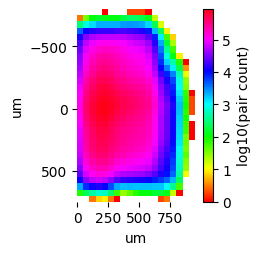

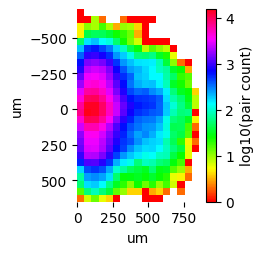

In [ ]:
count_all = (full_df_outgoing).groupby(["xz", "y"])["count"].sum()
I = numpy.log10(count_all.unstack("xz", fill_value=0))

fig = plt.figure(figsize=(2, 2.5))
plt.imshow(I, extent=make_extent(I), cmap="hsv")
plt.gca().set_frame_on(False)
plt.colorbar(label="log10(pair count)")
plt.gca().set_xlabel("um")
plt.gca().set_ylabel("um")

count_nn = (full_df_outgoing[full_df_outgoing["edges_nn"] > 0]).groupby(["xz", "y"])["count"].sum()
I = numpy.log10(count_nn.unstack("xz", fill_value=0))

fig = plt.figure(figsize=(2, 2.5))
plt.imshow(I, extent=make_extent(I), cmap="hsv")
plt.gca().set_frame_on(False)
plt.colorbar(label="log10(pair count)")
plt.gca().set_xlabel("um")
plt.gca().set_ylabel("um")

prior_post = full_df_outgoing.groupby(["xz", "y"]).apply(p_prior_post_fun)

## P-values
Next, we show whether the difference between the overall and conditional connection probability is statistically significant.
Here, we simply show for which spatial bins the p-value is 0 to within floating point accuracy.

As a test, we simply compare to the binomial distribution for the number of samples taken to assess conditional connection probability and for p=prior connection probability.

/Users/mwr/Documents/repositories/local_connectivity_model/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


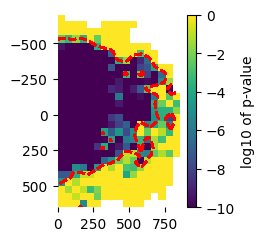

In [ ]:
from scipy.stats import binom
p_thresh = 0.01
min_log_p_displayed = -10
n = count_nn
p = prior_post["prior"][n.index]
v = count_nn * prior_post["posterior"][n.index]

p_values = pandas.Series(1 - binom(n, p).cdf(v - 1), index=n.index)
I = p_values.unstack("xz")

num_tests = (~I.isna()).sum().sum()
adjusted_p = p_thresh / num_tests

logI = numpy.log10(I)
logI[(logI < min_log_p_displayed) | (I == 0)] = min_log_p_displayed

fig = plt.figure(figsize=(2, 2.5))
plt.imshow(logI, extent=make_extent(I))
plt.gca().set_frame_on(False)
plt.colorbar(label="log10 of p-value")
plt.contour(logI.to_numpy()[::-1], levels=[numpy.log10(adjusted_p)], extent=make_extent(I), colors=["red"], antialiased=False)


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_59798/211366299.py:8: RuntimeWarning: divide by zero encountered in log10
  log_p_val_mat = numpy.log10(p_val_mat)


Text(0, 0.5, 'P for NN connected')

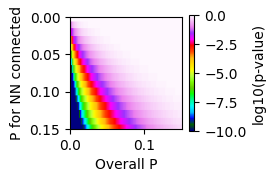

In [14]:
n = 100
p_prior_l = numpy.linspace(0, 0.15, 100)
p_post_l = numpy.linspace(0, 0.15, 100)
p_prior, p_post = numpy.meshgrid(p_prior_l, p_post_l)
n_post = numpy.round(n * p_post)

p_val_mat = 1 - binom(n, p_prior).cdf(n_post - 1)
log_p_val_mat = numpy.log10(p_val_mat)
log_p_val_mat[log_p_val_mat < -10] = -10
fig = plt.figure(figsize=(1.8, 1.5))
plt.imshow(log_p_val_mat, extent=(p_prior_l[0], p_prior_l[-1], p_post_l[-1], p_post_l[0]), cmap="gist_ncar")
plt.colorbar(label="log10(p-value)")
plt.gca().set_xlabel("Overall P")
plt.gca().set_ylabel("P for NN connected")